# Implementation of Adversarial Reprogramming

Code isn't very well organized as it was mainly experimenting and getting used to pytorch. The `models.py` file has the pytorch modules which I used to implement the reprogramming part. 

Run this whole notebook to train an adversarial reprogramming model on resnet18 using the scaled transform. 

In [1]:
import writefile_run
models_file = 'models.py'

In [2]:
%%writefile_run $models_file

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim

from pylab import *

In [3]:
DEVICE = torch.device('cpu')

In [4]:
rcParams['figure.figsize'] = 18,7
rcParams['axes.grid'] = True
rcParams['font.size'] = 15
style.use('dark_background')

In [5]:
from pytorch_utils.train_utils import *
from pytorch_utils.updaters import *

In [6]:
from torchvision.models import *
import torchvision

In [7]:
torch.backends.cudnn.benchmark=True

# Get the imagenet model

In [8]:
IMAGE_SIZE = (224,224)

In [9]:
model = resnet18(pretrained=True) # change this to try out different models

In [10]:
model.to(DEVICE)
model.eval();

In [11]:
params = nn.utils.parameters_to_vector(model.parameters())
params.shape

torch.Size([11689512])

In [12]:
test = torch.rand(1,3,*IMAGE_SIZE).to(DEVICE)
test.shape

torch.Size([1, 3, 224, 224])

In [13]:
with torch.no_grad():
    out = model(test)

In [14]:
out.shape

torch.Size([1, 1000])

## Get the data

In [15]:
from torchvision.datasets import *
from torchvision.transforms import *

In [16]:
transforms = Compose([Grayscale(3),
                      Resize(IMAGE_SIZE),
                      ToTensor()
                     ])

In [17]:
threshold=0.5
transforms_binarize = Compose(
    [
        Grayscale(3),
        Resize(IMAGE_SIZE),
        ToTensor(),
#         Lambda(lambda x:(x<threshold).float()),
        Lambda(lambda x:(1-x).float()),
    ]
)

In [18]:
total_train_mnist = MNIST('/MNIST',download=True,transform=transforms)
test_mnist = MNIST('/MNIST',train=False,transform=transforms)

Splitting:

In [19]:
training_number = len(total_train_mnist)
val_split = 0.1

train_num = int(training_number*(1-val_split))
val_num = int(training_number*val_split)

train_mnist, val_mnist = torch.utils.data.dataset.random_split(total_train_mnist, 
                [train_num, val_num])

In [20]:
batch_size = 32
train_loader = DataLoader(train_mnist, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_mnist, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_mnist, batch_size=batch_size,shuffle=True)
print(len(train_loader))

1688


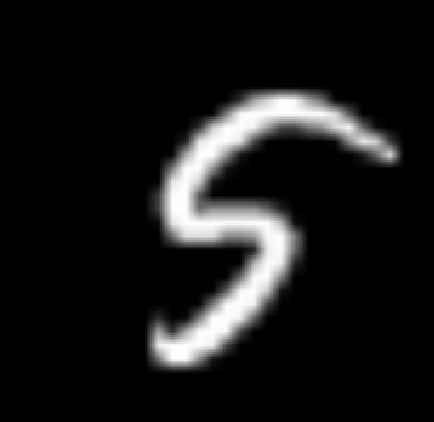

In [21]:
axis('off')
imshow(train_mnist[randint(1000)][0].numpy().transpose([1,2,0]))

# Models

In [22]:
%%writefile_run $models_file -a


class ReprogramMask(nn.Module):
    """Reprograms as 
    x = tanh(weight*mask)+pad(input)
    normalize(x)
    output = model(x)
    """
    def __init__(self, model, input_size, model_input_size, output_number):
        super().__init__()
        
        self.model = [model]
        self.output_number = output_number
        
        self.model[0].eval()
        for p in self.model[0].parameters():
            p.requires_grad=False
        
        
        inh, inw = input_size
        minh, minw = model_input_size
        
        self.padding = (minh-inh)//2, (minh-inh)//2 , (minw-inw)//2, (minw-inw)//2
        print(self.padding)
        
        self.mask = nn.Parameter(F.pad(torch.zeros(*input_size), self.padding, value=1.0), requires_grad=False)
        imshow(self.mask)
        # added weight
        self.weight = nn.Parameter(torch.randn(3,*model_input_size, requires_grad=True))
        
        
    def forward(self, input, plot_inp=False):
        padded_input = F.pad(input, self.padding)
        model_input = F.tanh(self.weight*self.mask)+padded_input
        normed_input = self.normalize_batch(model_input)
        if plot_inp:
            axis('off')
            imshow((model_input[0].detach().cpu().numpy().transpose([1,2,0])))
        out = self.model[0](normed_input)
        return out[:,:self.output_number]
    
    def normalize_batch(self, input, means=[0.485, 0.456, 0.406], stds=[0.229, 0.224, 0.225]):
        ms = torch.tensor(means, device=str(input.device)).view(1,3,1,1)
        ss = torch.tensor(stds, device=str(input.device)).view(1,3,1,1)
#         print(input.device)
#         print(ms.device)
#         out = input[:,:,:,:]
#         out[:,0,:,:] = (input[:,0,:,:] - means[0])/stds[0]
#         out[:,1,:,:] = (input[:,1,:,:] - means[1])/stds[1]
#         out[:,2,:,:] = (input[:,2,:,:] - means[2])/stds[2]
        return (input-ms)/ss

In [23]:
%%writefile_run $models_file -a


class Reprogram(nn.Module):
    """Reprograms as 
    x = sigmoid(2*(weight+input))
    normalize(x)
    output = model(x)
    """
    def __init__(self, model, model_input_size, output_number):
        super().__init__()
        
        self.model = [model]
        self.output_number = output_number
        
        self.model[0].eval()
        for p in self.model[0].parameters():
            p.requires_grad=False
        
        
        # added weight
        self.weight = nn.Parameter(torch.randn(3,*model_input_size, requires_grad=True))
        print(self.weight.requires_grad)
                
    def forward(self, input, plot_inp=False):
        model_input = F.sigmoid(2*(input+self.weight))
        normed_input = self.normalize_batch(model_input)
        if plot_inp:
            axis('off')
            imshow((model_input[0].detach().cpu().numpy().transpose([1,2,0])))
        out = self.model[0](normed_input)
        return out[:,:self.output_number]
    
    def normalize_batch(self, input, means=[0.485, 0.456, 0.406], stds=[0.229, 0.224, 0.225]):
        ms = torch.tensor(means, device=str(input.device)).view(1,3,1,1)
        ss = torch.tensor(stds, device=str(input.device)).view(1,3,1,1)
#         print(input.device)
#         print(ms.device)
#         out = input[:,:,:,:]
#         out[:,0,:,:] = (input[:,0,:,:] - means[0])/stds[0]
#         out[:,1,:,:] = (input[:,1,:,:] - means[1])/stds[1]
#         out[:,2,:,:] = (input[:,2,:,:] - means[2])/stds[2]
        return (input-ms)/ss

In [24]:
%%writefile_run $models_file -a


class ReprogramTanh(nn.Module):
    """Reprograms as 
    x = tanh(normalize(input)+weight)
    output = model(x)
    """
    def __init__(self, model, model_input_size, output_number):
        super().__init__()
        
        self.model = [model]
        self.output_number = output_number
        
        self.model[0].eval()
        for p in self.model[0].parameters():
            p.requires_grad=False
        
        
        # added weight
        self.weight = nn.Parameter(torch.randn(3,*model_input_size, requires_grad=True))
        print(self.weight.requires_grad)
                
    def forward(self, input, plot_inp=False):
        model_input = F.tanh(self.normalize_batch(input)+self.weight)
        if plot_inp:
            axis('off')
            imshow(0.5*(1+model_input[0].detach().cpu().numpy().transpose([1,2,0])))
        out = self.model[0](model_input)
        return out[:,:self.output_number]
    
    def normalize_batch(self, input, means=[0.485, 0.456, 0.406], stds=[0.229, 0.224, 0.225]):
        ms = torch.tensor(means, device=str(input.device)).view(1,3,1,1)
        ss = torch.tensor(stds, device=str(input.device)).view(1,3,1,1)
#         print(input.device)
#         print(ms.device)
#         out = input[:,:,:,:]
#         out[:,0,:,:] = (input[:,0,:,:] - means[0])/stds[0]
#         out[:,1,:,:] = (input[:,1,:,:] - means[1])/stds[1]
#         out[:,2,:,:] = (input[:,2,:,:] - means[2])/stds[2]
        return (input-ms)/ss

In [25]:
%%writefile_run $models_file -a


class ReprogramMult(nn.Module):
    """Reprograms as 
    x = sigmoid(weight)*input
    normalize(x)
    output = model(x)
    """
    def __init__(self, model, model_input_size, output_number):
        super().__init__()
        
        self.model = [model]
        self.output_number = output_number
        
        self.model[0].eval()
        for p in self.model[0].parameters():
            p.requires_grad=False
        
        
        # added weight
        self.weight = nn.Parameter(torch.randn(3,*model_input_size, requires_grad=True))
        print(self.weight.requires_grad)
                
    def forward(self, input, plot_inp=False):
        model_input = F.sigmoid(self.weight)*input
        normed_input = self.normalize_batch(model_input)
        if plot_inp:
            axis('off')
            imshow((model_input[0].detach().cpu().numpy().transpose([1,2,0])))
        out = self.model[0](normed_input)
        return out[:,:self.output_number]
    
    def normalize_batch(self, input, means=[0.485, 0.456, 0.406], stds=[0.229, 0.224, 0.225]):
        ms = torch.tensor(means, device=str(input.device)).view(1,3,1,1)
        ss = torch.tensor(stds, device=str(input.device)).view(1,3,1,1)
#         print(input.device)
#         print(ms.device)
#         out = input[:,:,:,:]
#         out[:,0,:,:] = (input[:,0,:,:] - means[0])/stds[0]
#         out[:,1,:,:] = (input[:,1,:,:] - means[1])/stds[1]
#         out[:,2,:,:] = (input[:,2,:,:] - means[2])/stds[2]
        return (input-ms)/ss

In [26]:
# arbitrary mapping
LABEL_NAMES = {
    0: "pineapple",
    1: "tree frog",
    2: "scorpion",
    3: "tick",
    4: "jellyfish",
    5: "egyptian cat",
    6: "bee",
    7: "bison",
    8: "abacus",
    9: "cardigan"
}

In [27]:
LABEL_MAPPING = torch.tensor([953, 31, 71, 78, 107, 285, 309, 347, 398, 474])
len(LABEL_MAPPING)

10

In [28]:
model_reprog = Reprogram(model, IMAGE_SIZE, 1000).to(DEVICE)

True


In [29]:
model_reprog.weight.data.fill_(0);

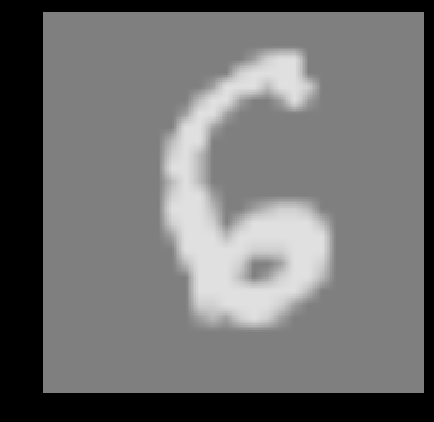

In [30]:
model_reprog(train_mnist[randint(1000)][0].view(1,3,*IMAGE_SIZE).to(DEVICE), plot_inp=True);

In [31]:
test_optimizer = optim.Adam([model_reprog.weight], lr=0.001, weight_decay=0)

loader = iter(train_loader)

In [32]:
im, lab = next(loader)
print(lab)
print(LABEL_MAPPING[lab], LABEL_MAPPING[lab].requires_grad)

tensor([ 1,  3,  7,  2,  7,  7,  8,  3,  6,  8,  1,  1,  3,  3,
         7,  4,  4,  6,  1,  0,  3,  5,  2,  8,  3,  2,  8,  5,
         9,  1,  5,  3])
tensor([  31,   78,  347,   71,  347,  347,  398,   78,  309,  398,
          31,   31,   78,   78,  347,  107,  107,  309,   31,  953,
          78,  285,   71,  398,   78,   71,  398,  285,  474,   31,
         285,   78]) False


In [33]:
%%timeit

# torch.cuda.synchronize()
# t0 = time.perf_counter()
input_test = next(loader)
criterion = nn.CrossEntropyLoss()
output = model_reprog(input_test[0].to(DEVICE))
loss = criterion(output, input_test[1].to(DEVICE))
test_optimizer.zero_grad()
loss.backward()
test_optimizer.step()
# torch.cuda.synchronize() 
# print('Time taken',time.perf_counter()-t0)

6.11 s ± 63.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
model_reprog = Reprogram(model, IMAGE_SIZE, 1000).to(DEVICE)

True


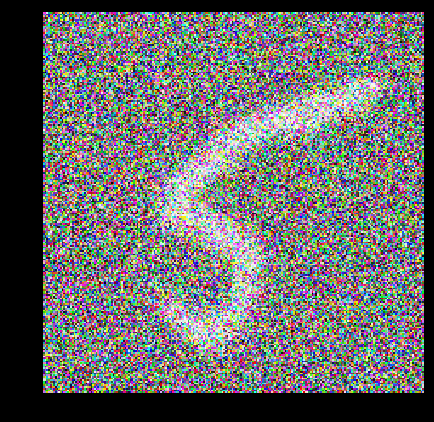

In [35]:
model_reprog(train_mnist[randint(1000)][0].view(1,3,*IMAGE_SIZE).to(DEVICE), plot_inp=True);

In [36]:
model_reprog.weight.data.fill_(0);

# Train functions

In [37]:
from skimage.filters import gaussian

In [38]:
glob_blur_sigma = 0.3
glob_blur_sigma_factor = 0.5

In [39]:
def gaussian_kernel(size=5, sigma=0.7):
    """Returns a 2D Gaussian kernel.
    Parameters
    ----------
    size : float, the kernel size (will be square)

    sigma : float, the sigma Gaussian parameter

    Returns
    -------
    out : array, shape = (size, size)
      an array with the centered gaussian kernel
    """
    x = np.linspace(-1,1,size)
    x /= np.sqrt(2)*sigma
    x2 = x**2
    kernel = np.exp(- x2[:, None] - x2[None, :])
    kernel = kernel / kernel.sum()
    return np.expand_dims(kernel, 0)

## Blur function

In [40]:
def blur(weight, sigma, size=5, padding=2):
    blur_kernel = torch.Tensor(gaussian_kernel(size=size, sigma=sigma)).to(DEVICE).repeat((1,1,1,1))
#     print(blur_kernel.requires_grad)
    weight[0] = F.conv2d(weight[0].unsqueeze(0).unsqueeze(0), blur_kernel, padding=padding)
    weight[1] = F.conv2d(weight[1].unsqueeze(0).unsqueeze(0), blur_kernel, padding=padding)
    weight[2] = F.conv2d(weight[2].unsqueeze(0).unsqueeze(0), blur_kernel, padding=padding)
    
    

## Train on batch

In [41]:
def trainOnBatch(model,batch,optimizer):
    
    # batch is tuple containing (tensor of images, tensor of labels)
    outputs = model(batch[0].to(DEVICE)) # forward pass
    
    # compute loss
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs,LABEL_MAPPING[batch[1]].to(DEVICE))
    
    # backward pass and weight update
    optimizer.zero_grad()
    loss.backward()
    
    old = model.weight.grad.cpu().detach().numpy()[:]
    
    s1 = old.std()
    
    #     blur grad
    with torch.no_grad():
        blur(model.weight.grad, sigma=glob_blur_sigma, size=5, padding=2)
    
    new = model.weight.grad.cpu().detach().numpy()
    
    s2 = new.std()

#     if s2==s1:
#         print('old and new same')
        
    optimizer.step()
    
#     blur weight
    with torch.no_grad():
        blur(model.weight, sigma=glob_blur_sigma, size=5, padding=2)


    # compute and return metrics
    loss = loss.detach().cpu().numpy()
    acc = accuracy(outputs, LABEL_MAPPING[batch[1]].to(DEVICE))
    
    return loss, acc

## Validation callback

Sorry for using globals

In [42]:
optimizer = optim.Adam([model_reprog.weight], lr=0.01, weight_decay=0.0)
glob_epoch_count = 0
epochs_to_zero_weight_decay = 3
epochs_to_reduce_lr = 20
glob_lr_decay_factor = 0.95

In [43]:
def callback(model, val_loader):
    with torch.no_grad(): # dont compute gradients
        global glob_epoch_count, glob_blur_sigma, glob_blur_sigma_factor, epochs_to_zero_weight_decay, epochs_to_reduce_lr
        global glob_lr_decay_factor
        glob_epoch_count +=1
        glob_blur_sigma *= glob_blur_sigma_factor
        
        criterion = nn.CrossEntropyLoss()
        
        model.eval() # eval mode
        
        batches = len(val_loader)
        loss=0
        acc=0
        for batch in val_loader:
            outputs = model(batch[0].to(DEVICE))
            loss += criterion(outputs,LABEL_MAPPING[batch[1]].to(DEVICE))
            acc += accuracy(outputs,LABEL_MAPPING[batch[1]].to(DEVICE))
        
        # find average loss and accuracy over whole vaildation set
        loss/= batches
        acc /= batches
        
        if glob_epoch_count==epochs_to_zero_weight_decay:
            print('weight decays set to 0')
            for p in optimizer.param_groups:
                p['weight_decay']=0
                
#         if glob_epoch_count==epochs_to_reduce_lr:
#             print('lrs set to 0.001')
#             for p in optimizer.param_groups:
#                 p['lr']=0.001
        
        for p in optimizer.param_groups:
                p['lr']*= glob_lr_decay_factor
            
        model.train() # go back to train mode
        
        # return metrics
        return loss.cpu().numpy(), acc

# Training setup

Sorry for not using a config file

In [44]:
save_dir = 'mnist_save_dir'
trainer = Trainer(model_reprog, trainOnBatch, callback=callback, 
                  save_dir=save_dir)
save_as_txt(LABEL_MAPPING, os.path.join(save_dir, 'LABEL_MAPPING.txt'))

In [45]:
trainer.setup_metrics(batch_metric_names=['loss','acc'], # trainOnBatch returns training loss and acc
                      callback_metric_names=['val_loss','val_acc'], # callback returns validation loss and acc
                      batch_metric_updaters=[averager, averager], # average the batch metrics over the epoch
                      save_name_metrics=['val_acc'], # Use the validation acc in checkpoint save names
                      fig_grid=(1,2), # 1 row, 2 cols
                      plot_grouping=[
                          ['loss','val_loss'], # first subplot for losses
                          ['acc','val_acc'] # second subplot for accuracies
                      ])

In [46]:
nn.utils.parameters_to_vector(model_reprog.parameters()).size()

torch.Size([150528])

# Run this cell to start the training

In [ ]:
metrics = trainer.loop(epochs=200, 
                       train_loader=train_loader,
                       optimizer=optimizer, 
                       val_loader=val_loader,
                       update_interval=1,
                       old_metrics=None)

In [ ]:
img = model_reprog.weight.data

In [ ]:
with torch.no_grad():
    axis('off')
    imshow((F.sigmoid(2*img).numpy().transpose([1,2,0])))